# Bias adjustment: Demonstration of simple application (single ensemble member)

## Tools for accessing and processing climate data: Case study with R

------------

This worked example uses R packages from the  climate4R framework, see the article ["climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias adjustment"](https://www.sciencedirect.com/science/article/pii/S1364815218303049).

## Table of Contents

* [Parameter Setting](#parameter-setting)
* [1. Library Loading](#1--library-loading)
* [2. Initial setups](#initial-setups)
* [3. Data Loading and Basic Visualization](#data-loading-and-basic-visualization)
    * [3.1. Data Loading of Decadal Predictions](#data-loading-of-decadal-predictions)
    * [3.2. Data Loading for the Observational Reference](#data-loading-for-the-observational-reference)
    * [3.3. Basic Data Visualization](#basic-data-visualization)
* [4. Bias adjustment](#bias-adjustment)
* [5. Bias adjustment in Cross-Validation Mode](#bias-adjustment-in-cross-validation-mode)
* [6. Bias adjustment of a Particular Lead-Year](#bias-adjustment-of-a-particular-lead-year)
    * [6.1. Data Loading of Decadal Predictions](#data-loading-of-decadal-predictions)
    * [6.2. Data Loading of the Observational Reference](#data-loading-of-the-observational-reference)
    * [6.3. Visualization of the Biases (Observation vs Prediction)](#visualization-of-the-biases-observation-vs-prediction)
    * [6.4. Bias adjustment and Visualization of the Results](#bias-adjustment-and-visualization-of-the-results)
* [7. Export the Results](#export-the-results)

In [1]:
options(java.parameters = "-Xmx10g")

---------
## Parameter setting

Here you can set a few parameters to change the notebook behaviour

### General parameters

Select city from the following options: "Barcelona", "Bergen", "Paris", "Prague".

Select the variable and specify the initialization year for the decadal prediction, ensuring it falls within the observational period range.

Indicate the initialization year for sections 1 to 5. It should be 1984 or later since the observations lack data before that year.

Specify the factor with which to upscale the observational grid.

Specify the path to the folder containing the data.

In [2]:
city <- "Paris" 
variable <- "tas"
initialization.year <- 1984 
obs.upscaling.factor <- 4
data.dir <- "../data/ncml"
output.dir <- "../output"
fig.dir <- "../figures"

### Bias adjustment parameters

Change or keep or add or remove parameters within the following list. Go to the help page of the `biasCorrection` function (by running `help(biascorrection)`) for further parametrization options and documentation.

In [3]:
bc.args <- list(
    # Bias adjustment method. Options are: "delta", "scaling", "eqm", "pqm", "gpqm", "loci", "dqm", "qdm", "isimip3"
    method = "eqm",
    # Scaling type (only used for method = "scaling")
    scaling.type = "additive",  # or "multiplicative"
    # Moving window width used to calibrate and the target days
    window = c(30, 30),
    # Arguments used if the method is parametric (i.e. method = "pqm")
    fitdistr.args = list(densfun = "normal"),
    # Set the precipitation parameter as TRUE if the variable being corrected is precipitation, and change the default wet threshold if desired.
    precipitation = FALSE,
    wet.threshold = 1,
    # Define the following parameters to apply the bias adjustment funtion in cross-validation mode
    cross.val = "none", # or "loo", or "kfold"
    folds = NULL, # or the list of year-periods defining the folds
    # Extrapolation 
    extrapolation = "constant" # or "none"
)

## 1. Library loading

In [4]:
library(loadeR)
library(loadeR.2nc)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(magrittr)
library(geoprocessoR)
library(sp)
library(repr)
options(repr.plot.width=10, repr.plot.height=4)

Loading required package: rJava

Loading required package: loadeR.java

Java version 22x amd64 by N/A detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

downscaleR version 3.3.4 (2023-06-22) is loaded

Please use 'citation("downscaleR")' to cite this package.

Please note that rgdal will be retired during October 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-7, (SVN revision 1203)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.8.5, released 2024/04/02
Path to GDAL shared files: /opt/conda/envs/climate4r/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.4.0, March 1st, 2024, [PJ_VERSION: 940]
Path to PROJ shared files: /home/jovyan/

## 2. Initial setups 

Definition of the geographical boundaries of each demonstrator:

In [5]:
domain <- switch(city,
  Barcelona = list(latLim = c(39, 44), lonLim = c(-1, 4)),
  Bergen = list(latLim = c(58, 63), lonLim = c(4, 9)),
  Paris = list(latLim = c(46.5, 51.5), lonLim = c(-1, 4.5)),
  Prague = list(latLim = c(47.5, 52.5), lonLim = c(12, 17))
)
city.centre <- switch(city,
  Barcelona = data.frame(x = 2.2, y = 41.4),
  Bergen = data.frame(x = 5.3, y = 60.4),
  Paris = data.frame(x = 2.3, y = 48.8),
  Prague = data.frame(x = 14.4, y = 50.1)
)

In [6]:
for (d in c(output.dir, fig.dir))
    if (! dir.exists(d))
        dir.create(d, recursive = TRUE)

Definition of the base name used to save the intermediate R data objects and to write the final NetCDF files:

In [7]:
(base.filename <- sprintf("%s/%s_%s_%s", output.dir, city, variable, bc.args$method))

[1] "../output/Paris_tas_eqm"

In [8]:
monmean <- function(x) aggregateGrid(x, aggr.m = list(FUN = "mean"))
yearmean <- function(x) aggregateGrid(x, aggr.y = list(FUN = "mean"))

## 3. Data loading and basic visualization

Datasets (NcML files):

In [9]:
ncml.dir <- sprintf("%s/EC-Earth3/dcppA-hindcast", data.dir)
datasets <- list.files(ncml.dir, full.names = T) 
head(datasets)

[1] "../data/ncml/EC-Earth3/dcppA-hindcast/s1960-r1i4p1f1_day_tas_gr_v20220322.ncml"
[2] "../data/ncml/EC-Earth3/dcppA-hindcast/s1961-r1i4p1f1_day_tas_gr_v20220322.ncml"
[3] "../data/ncml/EC-Earth3/dcppA-hindcast/s1962-r1i4p1f1_day_tas_gr_v20220322.ncml"
[4] "../data/ncml/EC-Earth3/dcppA-hindcast/s1963-r1i4p1f1_day_tas_gr_v20220322.ncml"
[5] "../data/ncml/EC-Earth3/dcppA-hindcast/s1964-r1i4p1f1_day_tas_gr_v20220322.ncml"
[6] "../data/ncml/EC-Earth3/dcppA-hindcast/s1965-r1i4p1f1_day_tas_gr_v20220322.ncml"

In [10]:
ncml.dir.obs <- sprintf("%s/CERRA", data.dir)
dataset.obs <- list.files(ncml.dir.obs, full.names = T) 
dataset.obs

[1] "../data/ncml/CERRA/tas_f3h-r2631x1113.ncml"

### 3.1. Data loading of decadal predictions

Example for the initialization year selected above, covering a 10-year period starting in November that year. E.g. Nov-1984 to Oct-1995, for `initialization.year = 1984`. 

Select the corresponding dataset:

In [11]:
(dataset.init <- grep(datasets, pattern = initialization.year, value = T))

[1] "../data/ncml/EC-Earth3/dcppA-hindcast/s1984-r1i4p1f1_day_tas_gr_v20220322.ncml"

Load data for the selected city domain. Parameter `years` is not specified, therefore all available years are retrieved.

In [12]:
city.pred <- loadGridData(dataset = dataset.init, 
                        var = variable,  
                        latLim = domain[["latLim"]],
                        lonLim = domain[["lonLim"]])

[2024-05-16 19:24:58.295442] Defining geo-location parameters

[2024-05-16 19:24:58.396651] Defining time selection parameters

[2024-05-16 19:24:58.463417] Retrieving data subset ...

[2024-05-16 19:25:38.317516] Done



Check the structure of the obtained object:

In [13]:
str(city.pred)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "tas"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Near-Surface Air Temperature"
  ..- attr(*, "units")= chr "K"
  ..- attr(*, "longname")= chr "tas"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:4017, 1:8, 1:8] 288 287 282 282 284 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 2
  ..$ x: num [1:8] -0.703 0 0.703 1.406 2.109 ...
  ..$ y: num [1:8] 46.7 47.4 48.1 48.8 49.5 ...
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "resX")= num 0.703
  ..- attr(*, "resY")= num 0.702
 $ Dates   :List of 2
  ..$ start: chr [1:4017] "1984-11-01 12:00:00 GMT" "1984-11-02 12:00:00 GMT" "1984-11-03 12:00:00 GMT" "1984-11-04 12:00:00 GMT" ...
  ..$ end  : chr [1:4017] "1984-11-01 12:00:00 GMT" "1984-11-02 12:00:00 GMT" "1984-11-03 

### 3.2. Data loading for the observational reference

The observational reference grid is high resolution, therefore, it is a common practice to perform an upscaling in order to avoid a big resolution mismatch. For eficiency, here  data loading is performed year by year and upscaled in each iteration. This operation takes a few minutes.

In [14]:
cache.file <- paste0(base.filename, "_city.obs.rda")
if (file.exists(cache.file)) {
    message("Reading from cache.")
    city.obs <- readRDS(cache.file)
} else {
    city.obs <- lapply(initialization.year : (initialization.year + 11), function(y) {
        message("Loading and upscaling year...", y)
        loadGridData(dataset.obs, 
                     var = variable, 
                     latLim = domain$latLim,
                     lonLim = domain$lonLim, 
                     years = y) %>%
        upscaleGrid(times = obs.upscaling.factor, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
        redim(drop = TRUE) %>% suppressMessages
    })
    saveRDS(city.obs, cache.file)
}

Reading from cache.



As the data loading has been performed in a loop of years, the next step is to obtain a single grid from the loaded list of grids, binding them over the time dimension.

In [15]:
city.obs <- bindGrid(city.obs, dimension = "time")

Temporally intersect the grids of the observation and the prediction to ensure consistency of the time period covered:

In [16]:
city.obs <- intersectGrid(city.obs, city.pred, type = "temporal", which.return = 1)
city.pred <- intersectGrid(city.obs, city.pred, type = "temporal", which.return = 2)

### 3.3. Basic data visualization

#### Temporal series for the spatial mean

pad applied on the interval: day

pad applied on the interval: day



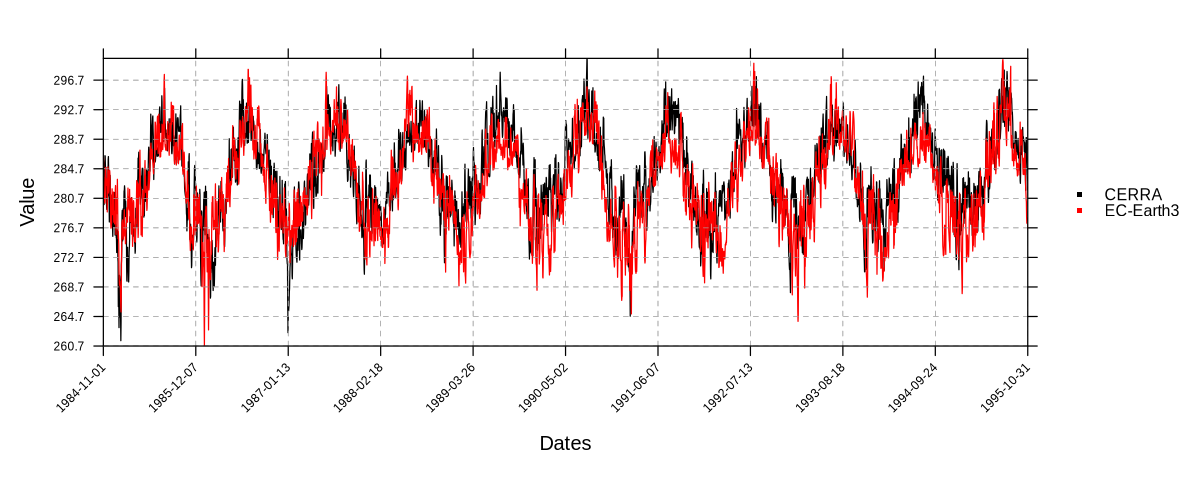

In [17]:
temporalPlot("CERRA" = city.obs, "EC-Earth3" = city.pred)

#### Maps of the climatological mean of the 10-year period

Set the coordinates for the central point representing the city.

In [18]:
coordinates(city.centre) <- ~ x + y

Map representation including the point correspondig to city centre for the observation first,

[2024-05-16 19:25:42.508855] - Computing climatology...

[2024-05-16 19:25:43.057993] - Done.



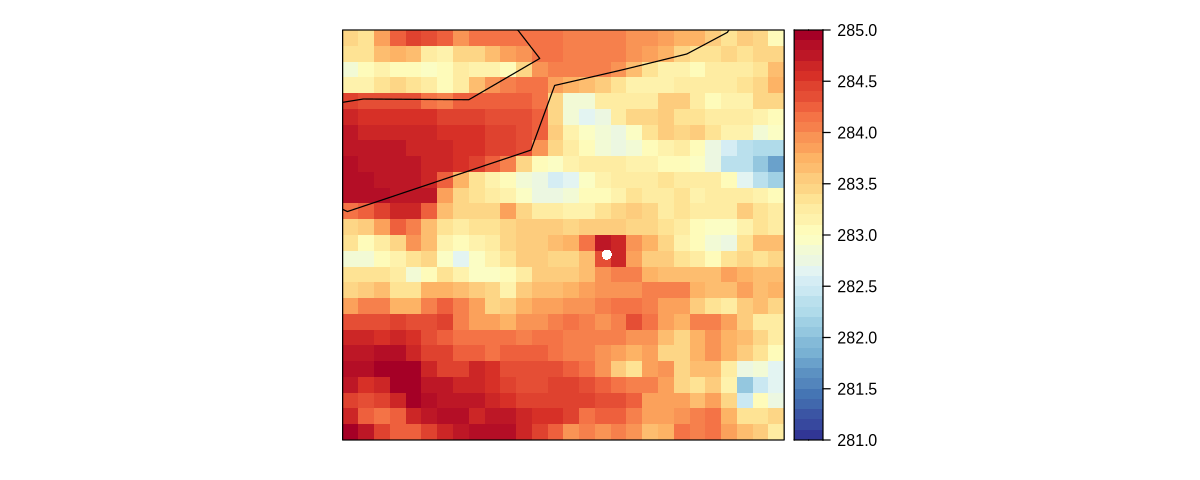

In [19]:
layout.city.centre <- list(list("sp.points", city.centre, pch = 16, cex = 1, col = "white"))
cbar.ticks <- seq(281, 285, 0.1)
spatialPlot(city.obs %>% climatology, 
            backdrop.theme = "coastline", 
            at = cbar.ticks, 
            set.max = max(cbar.ticks),
            rev.colors = TRUE,
            sp.layout = layout.city.centre)

and the prediction second:

[2024-05-16 19:25:43.404608] - Computing climatology...

[2024-05-16 19:25:43.411059] - Done.



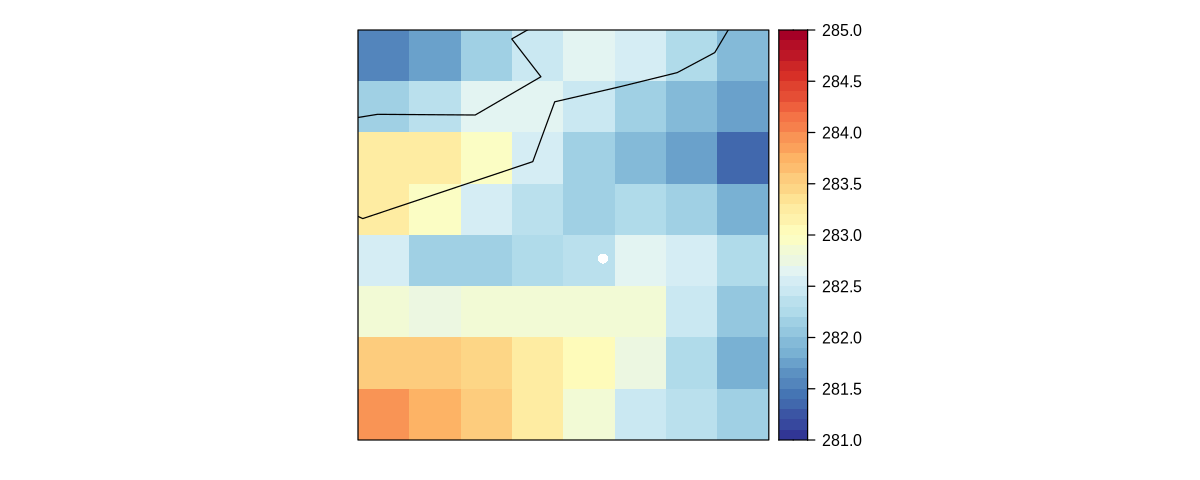

In [20]:
spatialPlot(city.pred %>% climatology, 
            backdrop.theme = "coastline",
            rev.colors = TRUE,
            at = cbar.ticks,
            sp.layout = layout.city.centre)

#### Visualization of the biases (observation vs prediction)

Decadal bias:

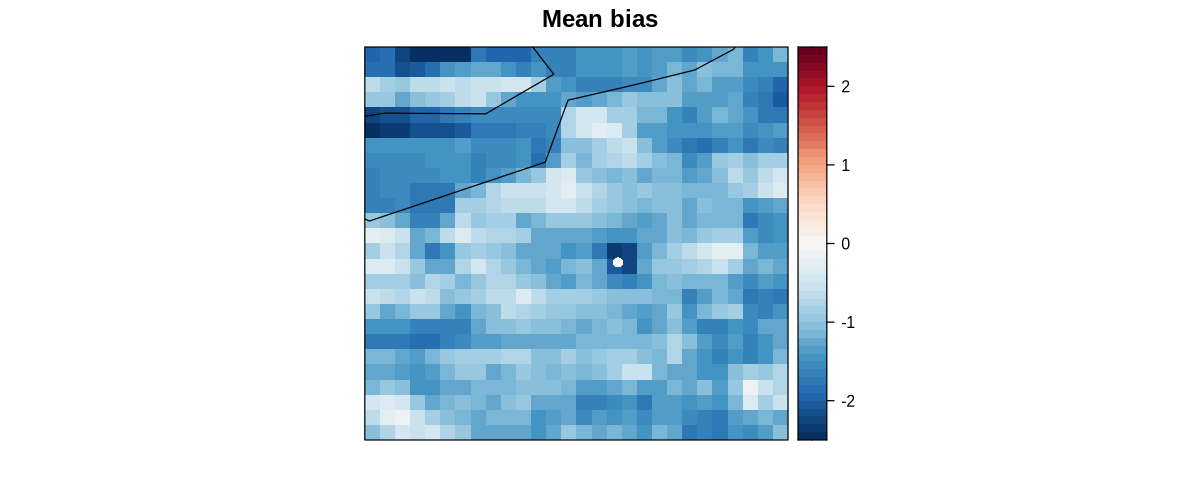

In [21]:
city.pred.i <- interpGrid(city.pred, new.coordinates = getGrid(city.obs)) %>% suppressMessages
diff <- gridArithmetics(city.pred.i %>% climatology, 
                        city.obs %>% climatology, 
                        operator = "-") %>% suppressMessages
cbar.ticks.bias <- seq(-2.5, 2.5, 0.1)
spatialPlot(diff, backdrop.theme = "coastline", at = cbar.ticks.bias, 
            set.max = max(cbar.ticks.bias),
            set.min = min(cbar.ticks.bias),
            color.theme = "RdBu",
            rev.colors = TRUE,
            main = "Mean bias",
            sp.layout = layout.city.centre)

Monthly mean series:

[2024-05-16 19:25:44.852625] Performing monthly aggregation...

[2024-05-16 19:25:45.382106] Done.

[2024-05-16 19:25:45.3962] Performing monthly aggregation...

[2024-05-16 19:25:45.440023] Done.

pad applied on the interval: month

pad applied on the interval: month



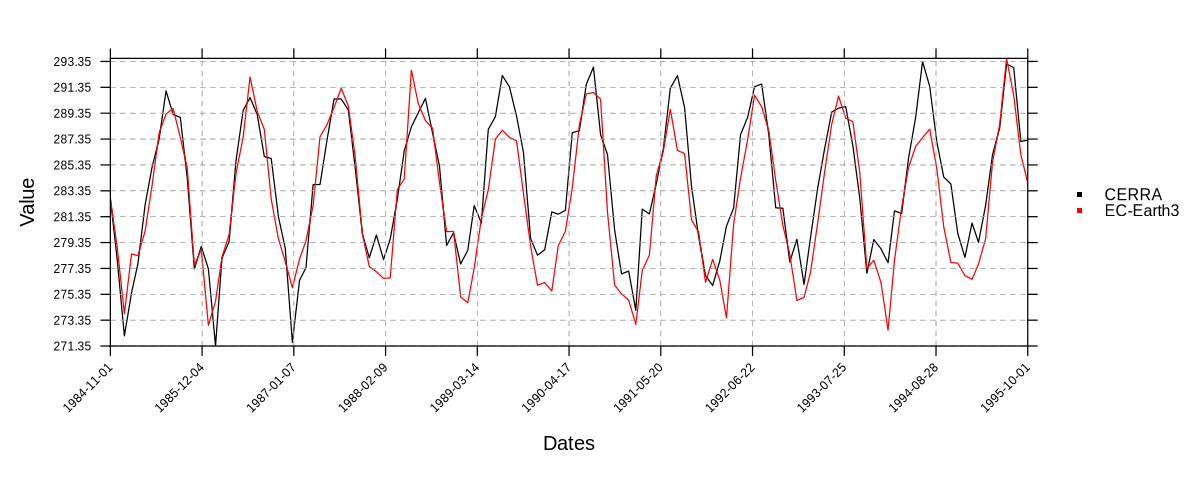

In [22]:
temporalPlot("CERRA" = monmean(city.obs), "EC-Earth3" = monmean(city.pred))

Annual mean series:

[2024-05-16 19:25:45.689906] Performing annual aggregation...

[2024-05-16 19:25:46.34993] Done.

[2024-05-16 19:25:46.362661] Performing annual aggregation...

[2024-05-16 19:25:46.378847] Done.

pad applied on the interval: year

pad applied on the interval: year



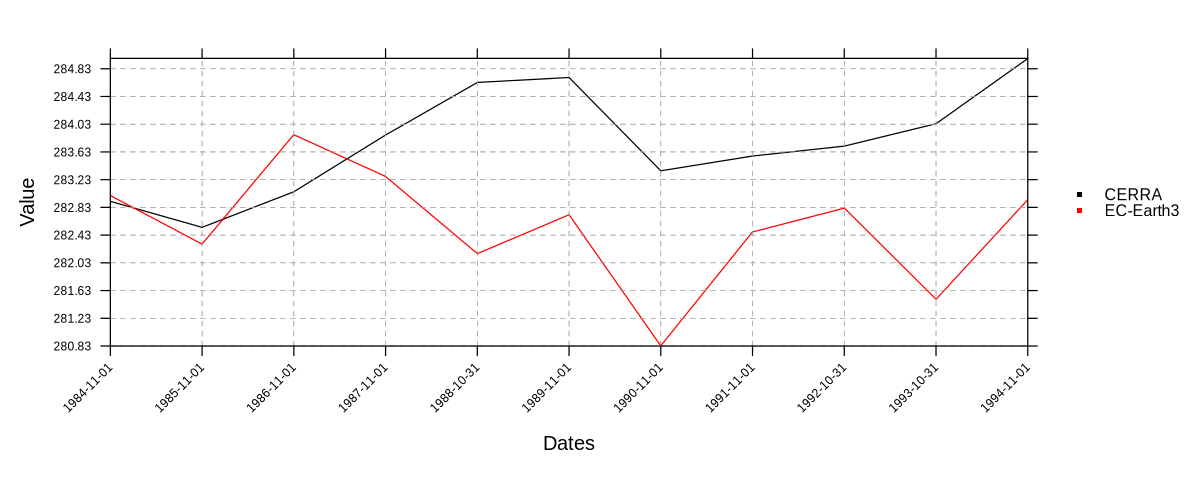

In [23]:
temporalPlot("CERRA" = yearmean(city.obs), "EC-Earth3" = yearmean(city.pred))

Quantile-quantile plot:

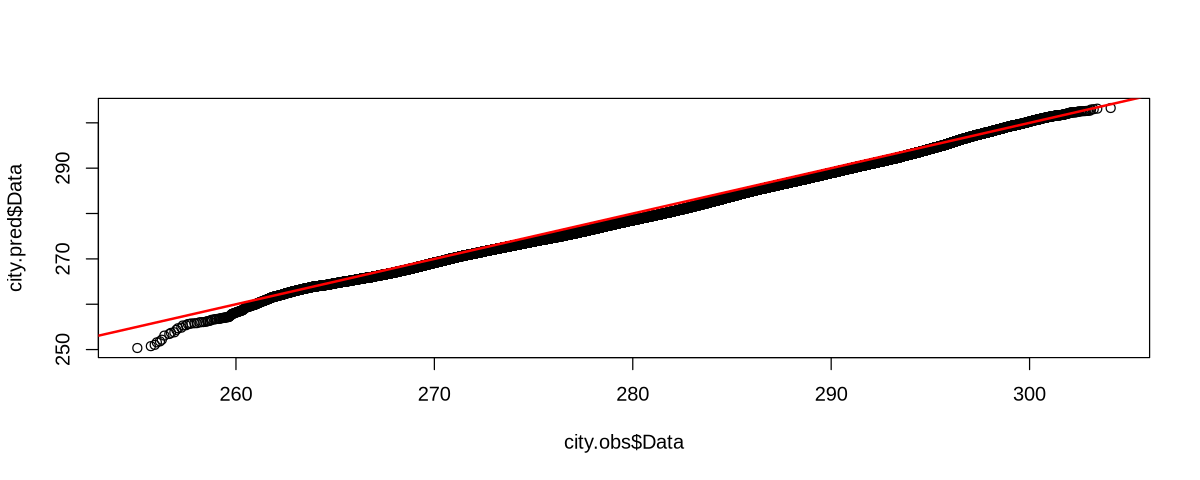

In [24]:
qqplot(city.obs$Data, city.pred$Data)
abline(0,1, col = "red", lwd = 2)

## 4. Bias adjustment

The `biasCorrection` function uses the nearest prediction grid-point to each observational grid-point for correcting the bias. Next, an example of application is illustrated. 

In order to apply the `biasCorrection` function using the parameters set at the beginning of this notebook, define the `x` and `y` slots of the parameter list assigning them the loaded grids. Then the `do.call` function is used.  

In [25]:
bc.args[["y"]] <- city.obs
bc.args[["x"]] <- city.pred

In [26]:
cal <- do.call("biasCorrection", bc.args)

[2024-05-16 19:25:52.276638] Trying to determine the time zone...

[2024-05-16 19:25:52.278371] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:25:53.56649] Already complete date record. Nothing was done

[2024-05-16 19:25:53.6015] Trying to determine the time zone...

[2024-05-16 19:25:53.603315] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:25:53.678161] Already complete date record. Nothing was done

[2024-05-16 19:25:53.68332] Trying to determine the time zone...

[2024-05-16 19:25:53.685083] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:25:53.752803] Already complete date record. Nothing was done

[2024-05-16 19:25:54.742243] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-05-16 19:25:57.101927] Number of windows considered: 12...

[2024-05-16 19:25:57.133152] Bias-co

In [27]:
cal$Dates <- lapply(cal$Dates, as.character)

#### Results comparison for the temporal mean:

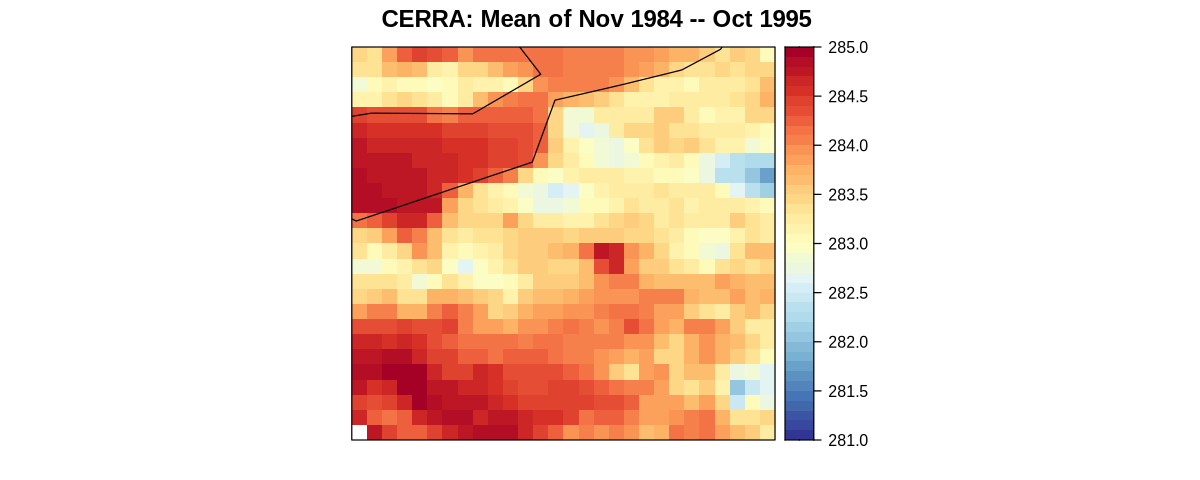

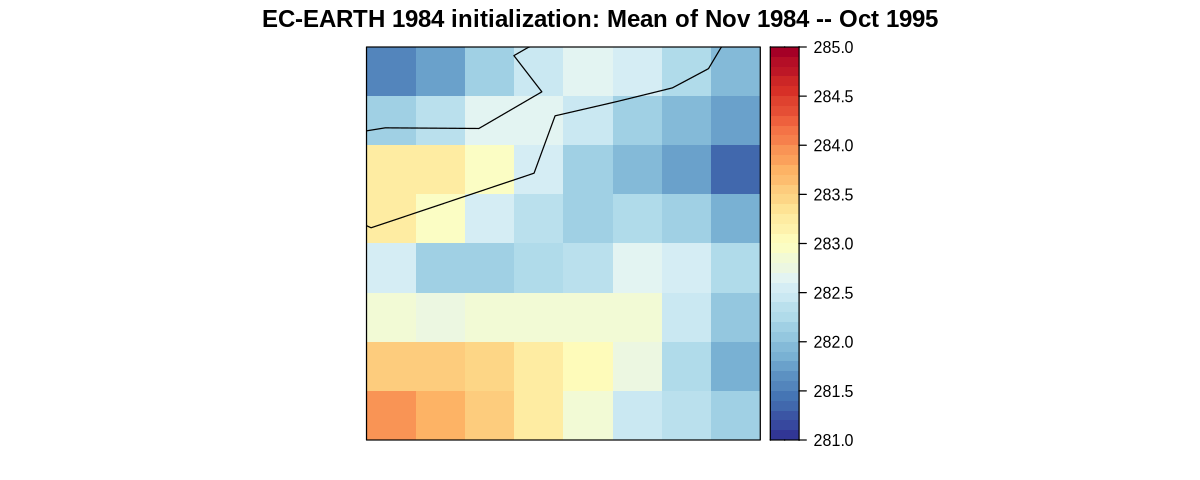

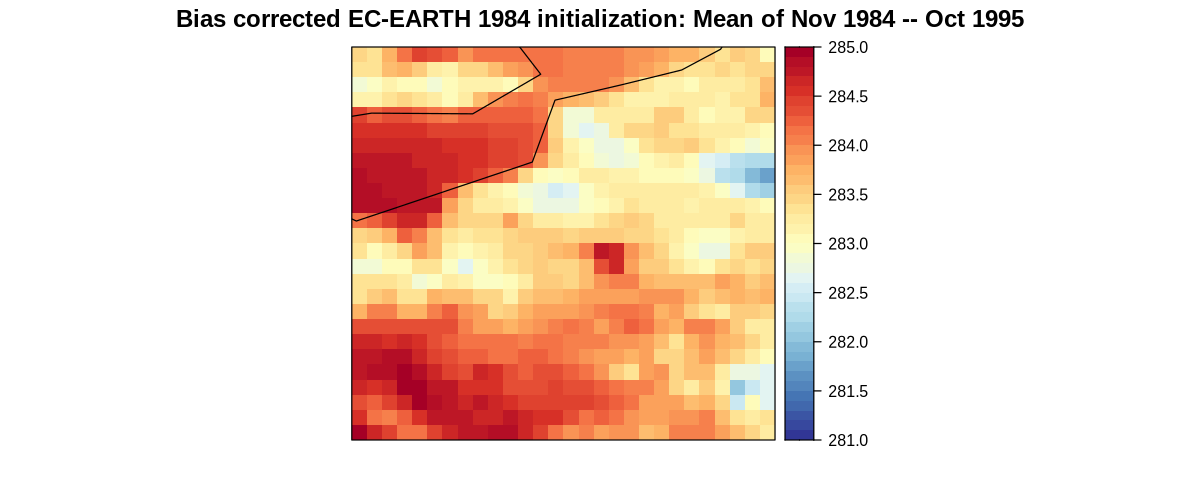

In [28]:
spatialPlot(city.obs %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "CERRA: Mean of Nov 1984 -- Oct 1995 ") %>% suppressMessages

spatialPlot(city.pred %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "EC-EARTH 1984 initialization: Mean of Nov 1984 -- Oct 1995") %>% suppressMessages

spatialPlot(cal %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "Bias corrected EC-EARTH 1984 initialization: Mean of Nov 1984 -- Oct 1995") %>% suppressMessages


#### Results comparison for the spatial mean:

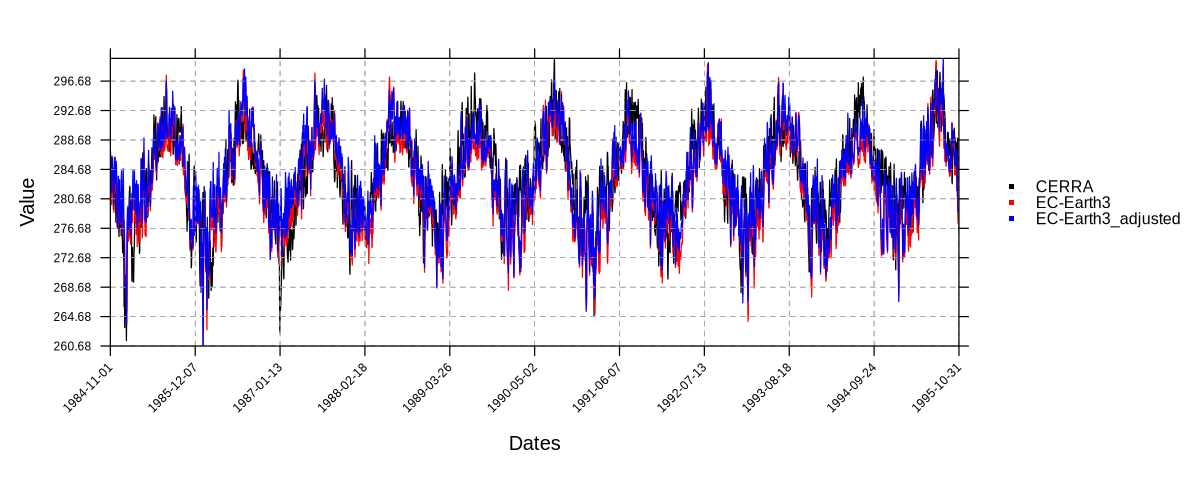

In [29]:
temporalPlot("CERRA" = city.obs, 
             "EC-Earth3" = city.pred,
             "EC-Earth3_adjusted" = cal) %>% suppressMessages

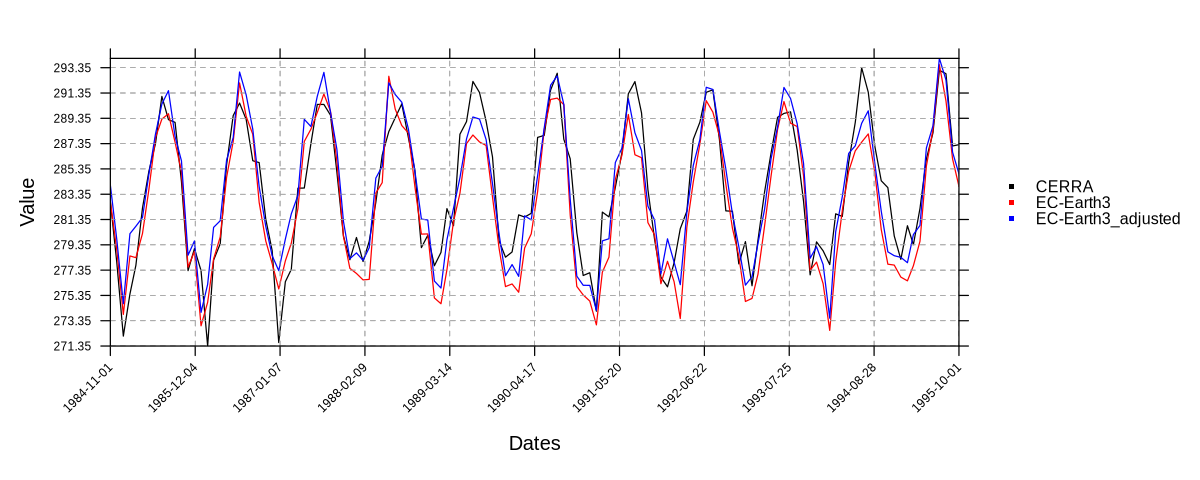

In [30]:
temporalPlot("CERRA" = monmean(city.obs), 
             "EC-Earth3" = monmean(city.pred),
             "EC-Earth3_adjusted" = monmean(cal)
) %>% suppressMessages

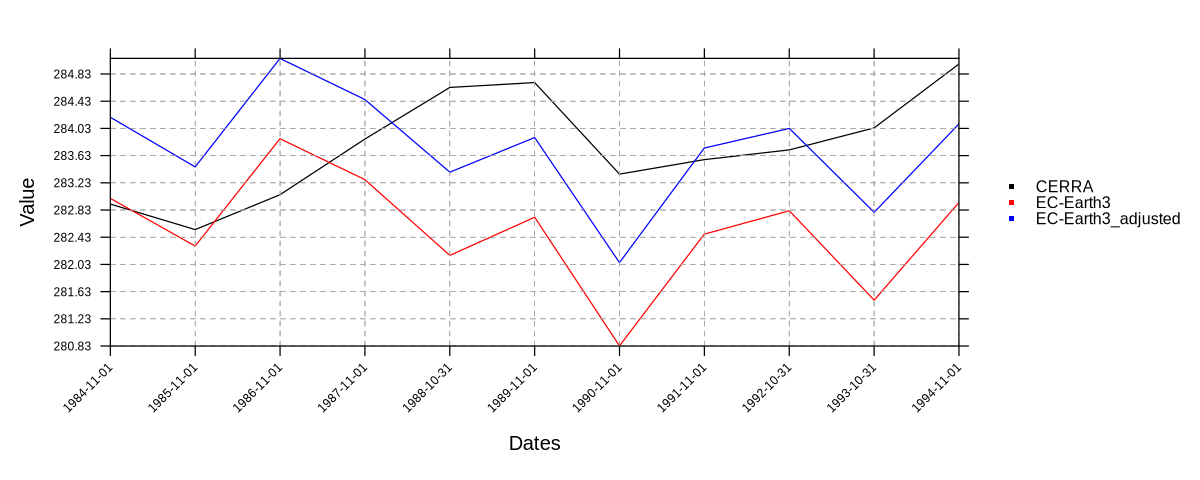

In [31]:
temporalPlot("CERRA" = yearmean(city.obs), 
             "EC-Earth3" = yearmean(city.pred),
             "EC-Earth3_adjusted" = yearmean(cal)
) %>% suppressMessages

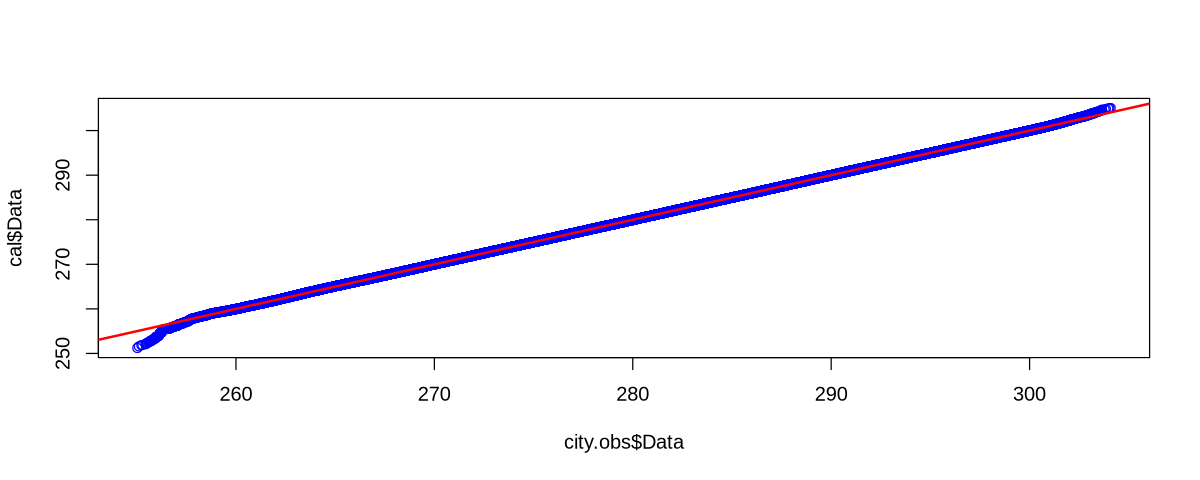

In [32]:
qqplot(city.obs$Data, cal$Data, col = "blue")
abline(0,1, col = "red", lwd = 2)

#### Results comparison for the point representing the city centre:

Extract the coordinates of the city centre:

In [33]:
x <- city.centre@coords[1,"x"]
y <- city.centre@coords[1,"y"]

Perform the monthly aggregation and the spatial subset:

In [34]:
o.city.centre.monthly <- monmean(city.obs) %>% subsetGrid(lonLim = x, latLim = y)
p.city.centre.monthly <- monmean(city.pred) %>% subsetGrid(lonLim = x, latLim = y)
c.city.centre.monthly <- monmean(cal) %>% subsetGrid(lonLim = x, latLim = y)

[2024-05-16 19:27:12.328192] Performing monthly aggregation...

[2024-05-16 19:27:12.850541] Done.

[2024-05-16 19:27:12.866871] Performing monthly aggregation...

[2024-05-16 19:27:12.91451] Done.

[2024-05-16 19:27:12.951028] Performing monthly aggregation...

[2024-05-16 19:27:14.090737] Done.



Plot the resulting time series:

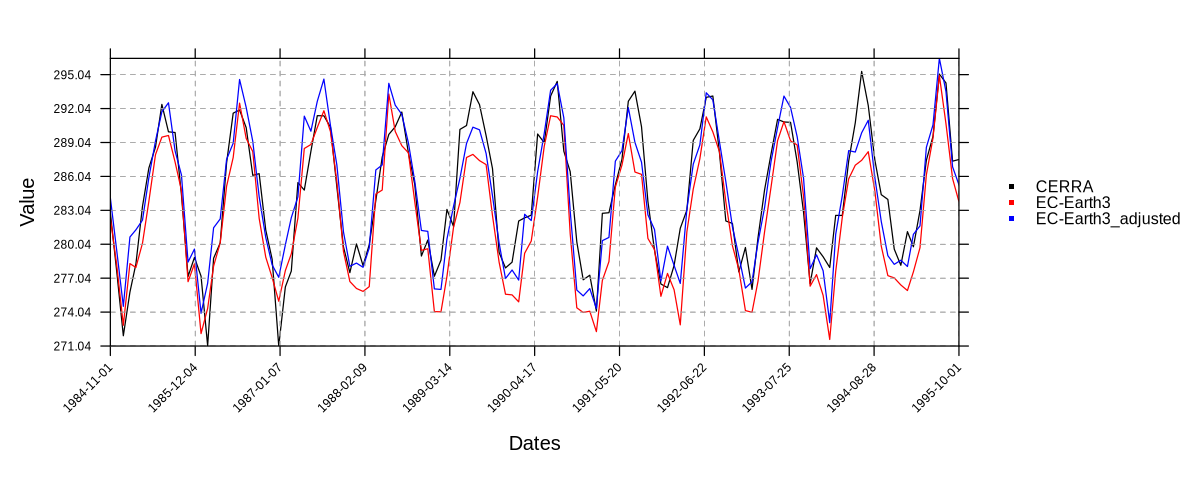

In [35]:
temporalPlot("CERRA" = o.city.centre.monthly, 
             "EC-Earth3" = p.city.centre.monthly,
             "EC-Earth3_adjusted" = c.city.centre.monthly) %>% suppressMessages

Repeat the operation but performing the annual aggregation this time:

In [36]:
o.city.centre.yearly <- yearmean(city.obs) %>% subsetGrid(lonLim = x, latLim = y)
p.city.centre.yearly <- yearmean(city.pred) %>% subsetGrid(lonLim = x, latLim = y)
c.city.centre.yearly <- yearmean(cal) %>% subsetGrid(lonLim = x, latLim = y)

[2024-05-16 19:27:14.361548] Performing annual aggregation...

[2024-05-16 19:27:14.5514] Done.

[2024-05-16 19:27:14.564508] Performing annual aggregation...

[2024-05-16 19:27:14.580816] Done.

[2024-05-16 19:27:14.611225] Performing annual aggregation...

[2024-05-16 19:27:14.823014] Done.



Plot the resulting time series

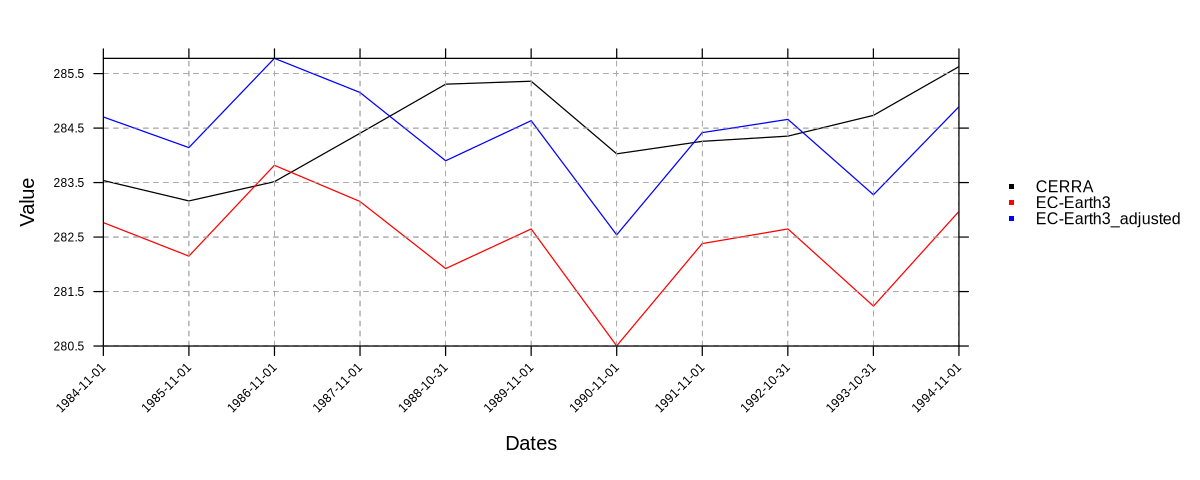

In [37]:
temporalPlot("CERRA" = o.city.centre.yearly, 
             "EC-Earth3" = p.city.centre.yearly,
             "EC-Earth3_adjusted" = c.city.centre.yearly) %>% suppressMessages

## 5. Bias adjustment in cross-validation mode

The `biasCorrection` function implements the option to perform a cross-validation. Next an example of application is illustrated, for a k-fold cross-validation leaving one year out in each iteration,

In order to apply the `biasCorrection` function in cross-validation mode using the parameters set at the beginning of this notebook, define the `cross.val` and `folds` slots of the parameter list. Then the `do.call` function is used.  

In [38]:
bc.args[["cross.val"]] <- "kfold"
bc.args[["folds"]] <- as.list((initialization.year+1):(initialization.year + 10))

In [39]:
cal.cv <- do.call("biasCorrection", bc.args) 

[2024-05-16 19:27:15.048735] Trying to determine the time zone...

[2024-05-16 19:27:15.050306] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:27:15.938838] Already complete date record. Nothing was done

[2024-05-16 19:27:15.979059] Trying to determine the time zone...

[2024-05-16 19:27:15.981226] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:27:16.061012] Already complete date record. Nothing was done

[2024-05-16 19:27:16.066174] Trying to determine the time zone...

[2024-05-16 19:27:16.068073] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-16 19:27:16.137036] Already complete date record. Nothing was done

Validation 1, 9 remaining

[2024-05-16 19:27:17.113613] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-05-16 19:27:18.053832] Number of windows considered: 12...

[2024

In [40]:
cal.cv$Dates <- lapply(cal.cv$Dates, as.character)

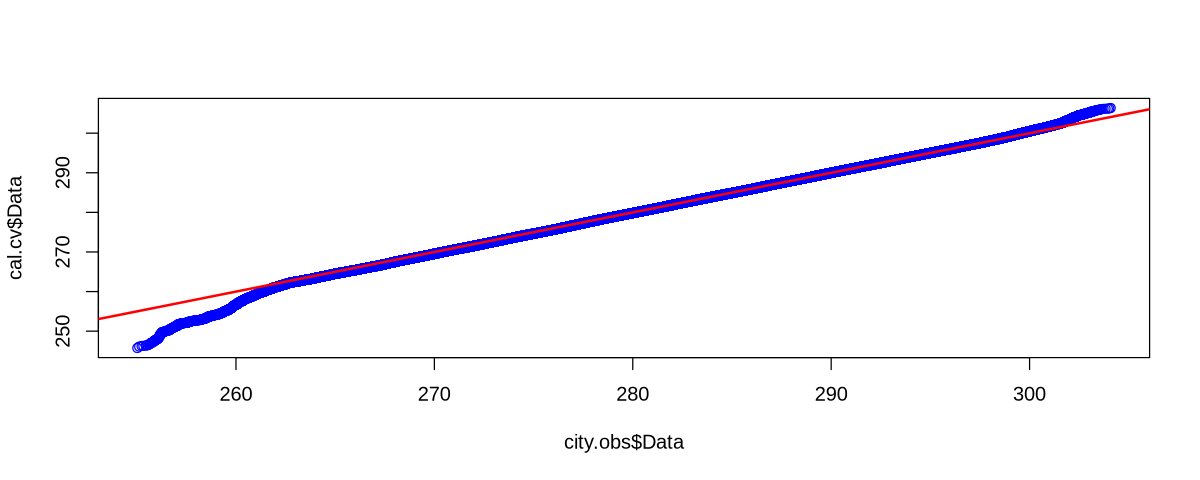

In [41]:
qqplot(city.obs$Data, cal.cv$Data, col = "blue")
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

## 6. Bias adjustment of a particular lead-year 
### 6.1. Data loading of decadal predictions

In this case we need to load data from each of the datasets we have previously created. We exclude data before 1984 because the observational reference does not contain data prior to this year.

In [42]:
datasets <- datasets[(datasets %>% grep(pattern = initialization.year)) : length(datasets)] %<>% print

 [1] "../data/ncml/EC-Earth3/dcppA-hindcast/s1984-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [2] "../data/ncml/EC-Earth3/dcppA-hindcast/s1985-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [3] "../data/ncml/EC-Earth3/dcppA-hindcast/s1986-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [4] "../data/ncml/EC-Earth3/dcppA-hindcast/s1987-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [5] "../data/ncml/EC-Earth3/dcppA-hindcast/s1988-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [6] "../data/ncml/EC-Earth3/dcppA-hindcast/s1989-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [7] "../data/ncml/EC-Earth3/dcppA-hindcast/s1990-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [8] "../data/ncml/EC-Earth3/dcppA-hindcast/s1991-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [9] "../data/ncml/EC-Earth3/dcppA-hindcast/s1992-r1i4p1f1_day_tas_gr_v20220322.ncml"
[10] "../data/ncml/EC-Earth3/dcppA-hindcast/s1993-r1i4p1f1_day_tas_gr_v20220322.ncml"
[11] "../data/ncml/EC-Earth3/dcppA-hindcast/s1994-r1i4p1f1_day_tas_gr_v20220322.ncml"
[12] "../data/ncml/EC-Earth3/dcppA-hindcast/s1995-r1i4

#### Create the lead-year x series
In this example we create the **lead-year 1** series. Got to notebook `2024_ensemble_bias_adjustment.ipynb` for the creation of the ensemble of all lead-years.

In [43]:
if (!file.exists(paste0(base.filename, "_city.pred.ly1.l.rda"))) {

    city.pred.ly1.l <- lapply(datasets, function(d) {
        di <- dataInventory(d) 
        y <- di[[variable]]$Dimensions$time$Date_range %>%  substring(first = 1, last = 4) %>% as.numeric 
        g1 <- loadGridData(d, 
                           years = y, 
                           season = 11:12,
                           var = variable,  
                           latLim = domain$latLim,
                           lonLim = domain$lonLim) 
        g2 <- loadGridData(d, 
                           years = y + 1, 
                           season = 1:10,                 
                           var = variable,  
                           latLim = domain$latLim,
                           lonLim = domain$lonLim) 
        bindGrid(g1, g2, dimension = "time") 
    }) %>% suppressMessages

    saveRDS(city.pred.ly1.l, paste0(base.filename, "_city.pred.ly1.l.rda"))
    
} else {

    city.pred.ly1.l <- readRDS(paste0(base.filename, "_city.pred.ly1.l.rda"))
    
}


The result is a list of grids corresponding to consecutive time-chunks:

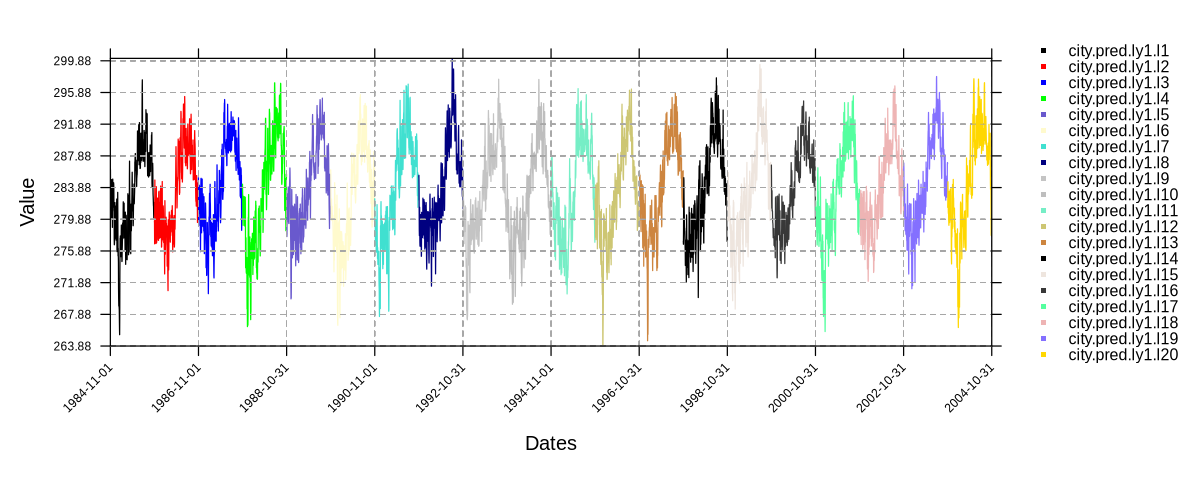

In [44]:
temporalPlot(city.pred.ly1.l) %>% suppressMessages

Bind them all in an unique grid:

In [45]:
city.pred.ly1 <- do.call("bindGrid", c(city.pred.ly1.l, dimension = "time"))

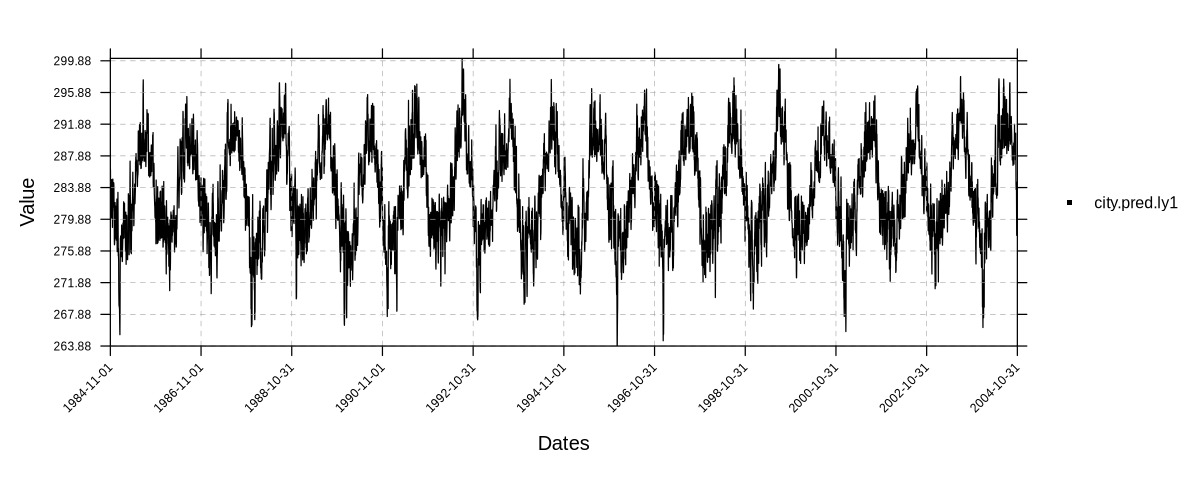

In [46]:
temporalPlot(city.pred.ly1) %>% suppressMessages

### 6.2. Data loading of the observational reference

Extract the years in the prediction to load the same years for the observational reference:

In [47]:
years <- getRefDates(city.pred.ly1) %>% substring(first = 1, last = 4) %>% unique

For eficiency, load and upscale in a years loop:

In [48]:
if (!file.exists(paste0(base.filename, "_city.obs.long.rda"))) {
    
    city.obs.long <- lapply(years, function(y) {
        message("Loading and upscaling year...", y)
        loadGridData(dataset.obs, 
                     var = variable, 
                     latLim = domain$latLim,
                     lonLim = domain$lonLim, 
                     years = y) %>% 
        upscaleGrid(times = obs.upscaling.factor, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
        redim(drop = TRUE) %>%
        suppressMessages
    })

    saveRDS(city.obs.long, paste0(base.filename, "_city.obs.long.rda"))
    
} else {

    readRDS(paste0(base.filename, "_city.obs.long.rda"))
    
}

Loading and upscaling year...1984

Loading and upscaling year...1985

Loading and upscaling year...1986

Loading and upscaling year...1987

Loading and upscaling year...1988

Loading and upscaling year...1989

Loading and upscaling year...1990

Loading and upscaling year...1991

Loading and upscaling year...1992

Loading and upscaling year...1993

Loading and upscaling year...1994

Loading and upscaling year...1995

Loading and upscaling year...1996

Loading and upscaling year...1997

Loading and upscaling year...1998

Loading and upscaling year...1999

Loading and upscaling year...2000

Loading and upscaling year...2001

Loading and upscaling year...2002

Loading and upscaling year...2003

Loading and upscaling year...2004



Optioanl saving of the resulting objecto to save time in the future.

Bind the resulting list of grids into the same grid:

In [49]:
city.obs.long <- bindGrid(city.obs.long, dimension = "time")

Temporally intersect the grids of the observation and the prediction to ensure consistency of the time period covered:

In [50]:
city.obs.long <- intersectGrid(city.obs.long, city.pred.ly1, type = "temporal", which.return = 1)

### 6.3. Visualization of the biases (observation vs prediction)

Decadal bias:

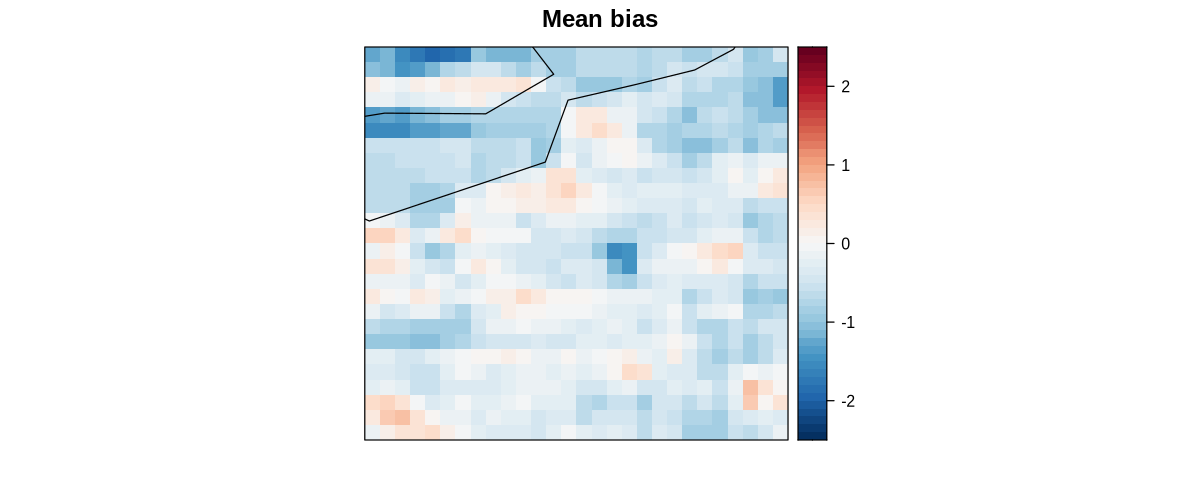

In [51]:
city.pred.ly1.i <- interpGrid(city.pred.ly1, new.coordinates = getGrid(city.obs.long)) %>% suppressMessages
diff <- gridArithmetics(city.pred.ly1.i %>% climatology, 
                        city.obs.long %>% climatology, 
                        operator = "-") %>% suppressMessages
spatialPlot(diff, backdrop.theme = "coastline", at = seq(-2.5, 2.5, 0.1), 
            color.theme = "RdBu",
            rev.colors = TRUE,
            main = "Mean bias")

In [52]:
city.pred.ly1.i <- NULL

Daily series:

pad applied on the interval: day

pad applied on the interval: day



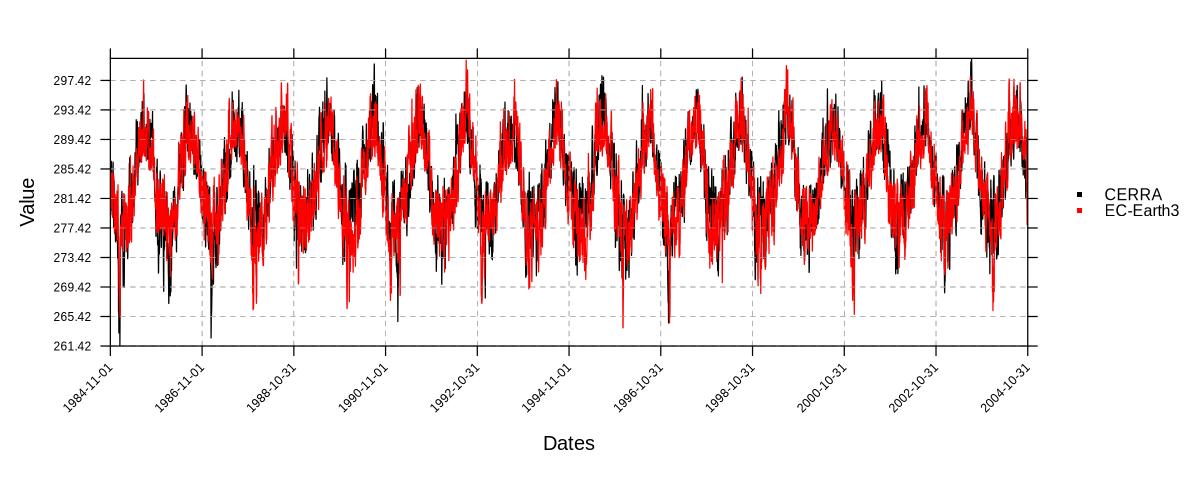

In [53]:
temporalPlot("CERRA" = city.obs.long, "EC-Earth3" = city.pred.ly1)

Monthly mean series:

[2024-05-16 19:46:22.811213] Performing monthly aggregation...

[2024-05-16 19:46:24.292938] Done.

[2024-05-16 19:46:24.317462] Performing monthly aggregation...

[2024-05-16 19:46:24.405463] Done.

pad applied on the interval: month

pad applied on the interval: month



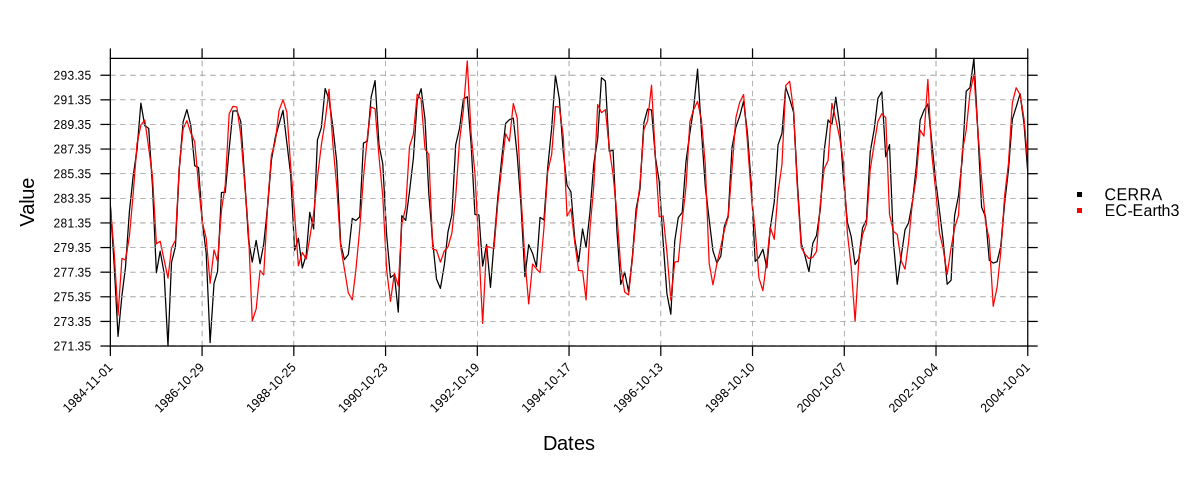

In [54]:
temporalPlot("CERRA" = city.obs.long %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = city.pred.ly1 %>% aggregateGrid(aggr.m = list(FUN = "mean")))

Annual mean series:

[2024-05-16 19:46:24.698466] Performing annual aggregation...

[2024-05-16 19:46:25.014126] Done.

[2024-05-16 19:46:25.034707] Performing annual aggregation...

[2024-05-16 19:46:25.065524] Done.

pad applied on the interval: year

pad applied on the interval: year



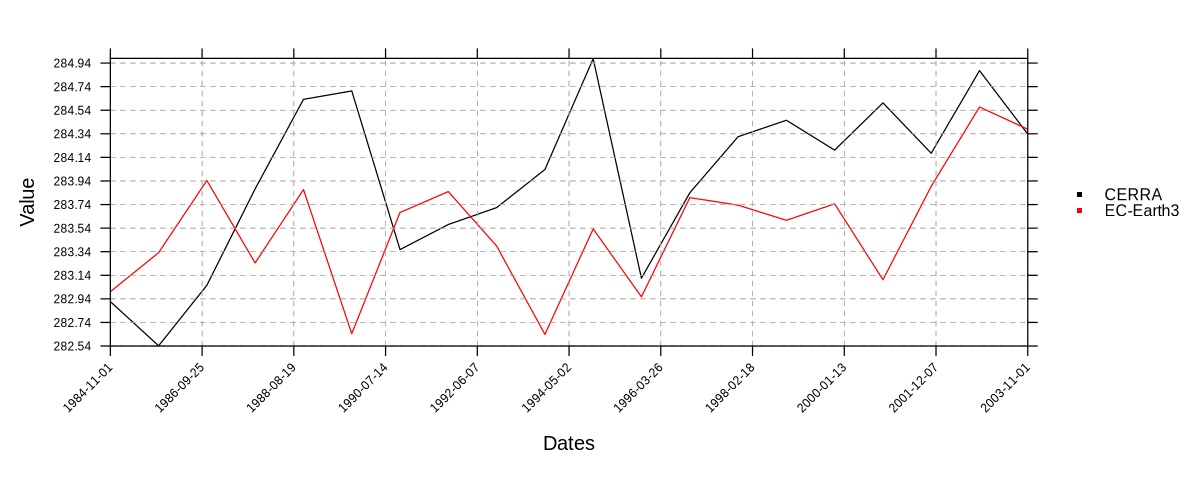

In [55]:
temporalPlot("CERRA" = city.obs.long %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = city.pred.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean")))

Quantile-quantile plot:

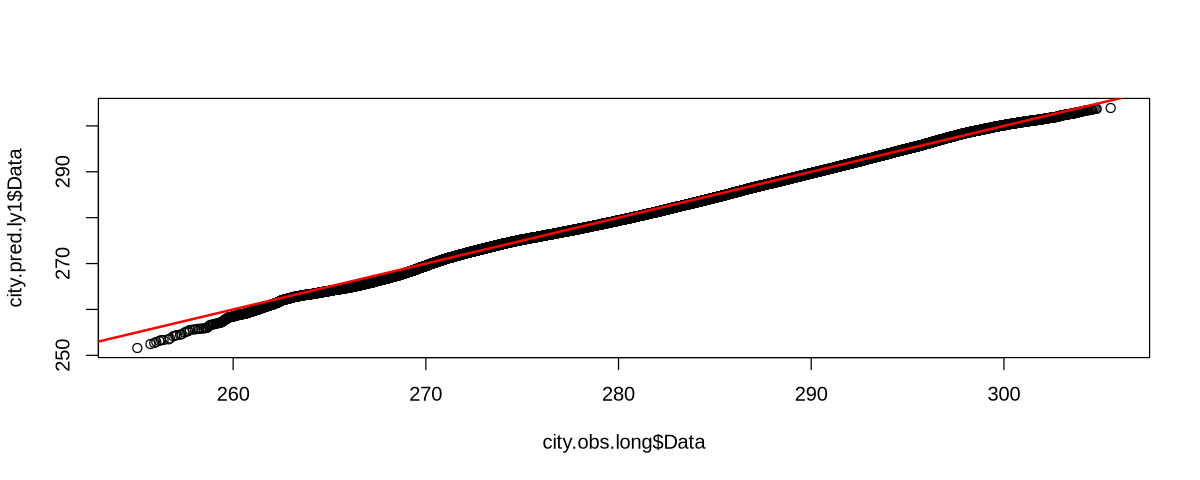

In [56]:
qqplot(city.obs.long$Data, city.pred.ly1$Data)
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

### 6.4. Bias adjustment and visualization of the results



In order to apply the `biasCorrection` function using the parameters set at the beginning of this notebook, define the `x` and `y` slots of the parameter list assigning them the loaded grids. Redefine the `cross.val` and `folds` parameters as well. Then the `do.call` function is used.  

In [57]:
bc.args[["y"]] <- city.obs.long
bc.args[["x"]] <- city.pred.ly1
bc.args[["cross.val"]] <- "none"
bc.args[["folds"]] <- NULL

In [58]:
cal.ly1 <- do.call("biasCorrection", bc.args) %>% suppressMessages

In [59]:
cal.ly1$Dates <- lapply(cal.ly1$Dates, as.character)

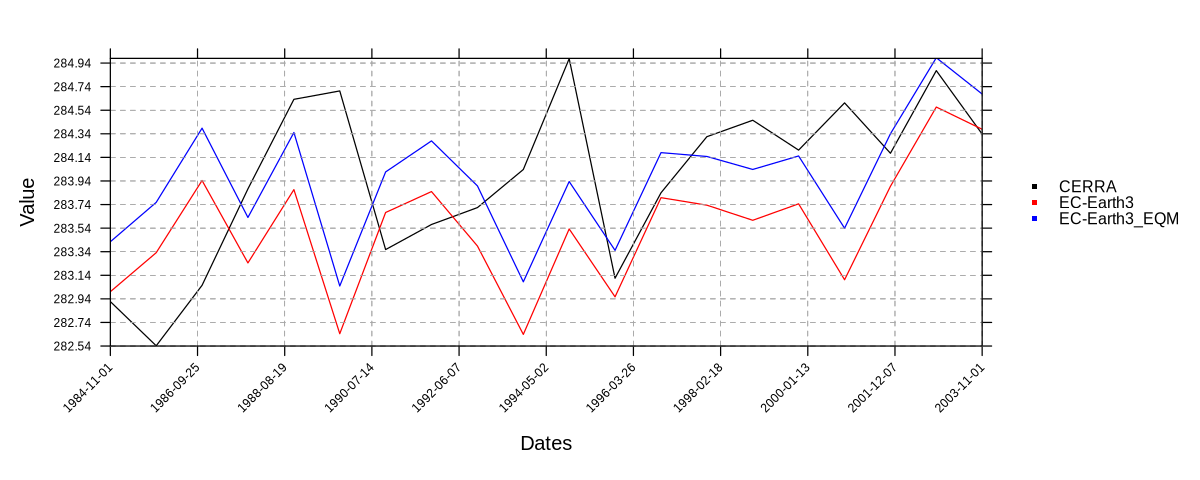

In [60]:
temporalPlot("CERRA" = city.obs.long %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = city.pred.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean")),
             "EC-Earth3_EQM" = cal.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean"))) %>% suppressMessages

## 7. Export the results

In [61]:
grid2nc(cal, NetCDFOutFile = paste0(base.filename, "_", initialization.year, ".nc"))
grid2nc(cal.cv, NetCDFOutFile = paste0(base.filename, "_", initialization.year, "_kfold.nc"))
grid2nc(cal.ly1, NetCDFOutFile = paste0(base.filename, "_lead-year1.nc"))

[2024-05-16 19:47:06.528585] NetCDF file written in: ../output/Paris_tas_eqm_1984.nc

[2024-05-16 19:47:07.152996] NetCDF file written in: ../output/Paris_tas_eqm_1984_kfold.nc

[2024-05-16 19:47:08.547582] NetCDF file written in: ../output/Paris_tas_eqm_lead-year1.nc

